# Deep Learning for Stock Price Prediction #

In this notebook we use a deep learning machine to predict the stock price of IBM. We train the machine on historical data pulled from the Alpha Vantage API. The following was completed as part of a project offered by Alpha Academy. 

***
## Libraries ## 

We import the various libraries and tools we will use in the project.

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from alpha_vantage.timeseries import TimeSeries 

We also import our API key. 

In [2]:
from keys import ALPHAVANTAGE_API_KEY

***
## Configuration ## 

We now set the following configurations for the project and store these settings in a dictionary called `config`. Note that we are using our API key and that the stock symbol has been chosen as `IBM`. The dict `config` will then be passed into a function to handle the API requests.

In [3]:
config = {
    "alpha_vantage": {
        "key": ALPHAVANTAGE_API_KEY,
        "symbol": "IBM",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,   # 80/20 split for training/validation
    }, 
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

*** 
## Data Preparation and Visualization ## 

We will now pull data from the Alpha Vantage API and plot the data using matplotlib.

### Acquiring Data from Alpha Vantage API ###

We first create a `download_data` function which processes the API call and returns the stock data.

In [4]:
def download_data(config):
    ts = TimeSeries(key=config["alpha_vantage"]["key"]) 
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()]
    data_date.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points", num_data_points, display_date_range)

    return data_date, data_close_price, num_data_points, display_date_range

We now run the function and store the output into the appropriate variables. 

In [16]:
data_date, data_close_price, num_data_points, display_date_range = download_data(config)

Number data points 5842 from 1999-11-01 to 2023-01-19


### Plotting the Data ###

We now plot the market data.

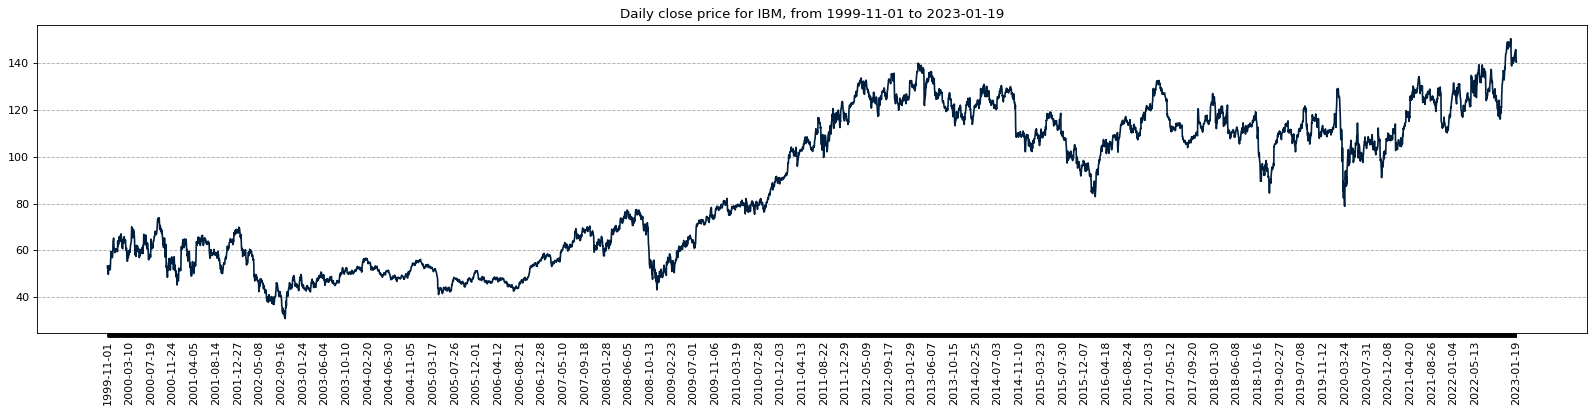

In [6]:
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.show()

Note that the closing price that is being plotted above is the **adjusted** daily close price. This is an industry best-practice, as the adjusted price removes any stock turbulence associated with stock splits and dividend payouts. 

### Normalizing Raw Financial Data ###

We are going to build a _Long short-term machine_ (LSTM) to predict the future stock price of IBM. Machine learning algorithms such as LSTM use _gradient descent_ (take repeated steps in the opposite direction to the gradient) to optimize. However, gradient descent requires the data to be feature scaled. 

We therefore require _data normalization_. This will increase the accuracy of our model and help the gradient descent algorithm converge more quickly. Since stock prices range from tens to hundreds and thousands, we will perform the normalization to standardized the range of values before feeding the data into the LSTM. 

The following class and methods renormalize the data so that it has a mean of 0 and an standard deviation of 1. It also has a method to reverse the transformation. 

In [7]:
class Normalizer():
    def __init__(self):
        self.mu = None 
        self.sd = None
    
    def fit_transform(self, x):
        self.mu = np.mean(x, axis = (0), keepdims = True)
        self.sd = np.std(x, axis = (0), keepdims = True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x
    
    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

We can now normalize the closing price data. 

In [8]:
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)

### Generating Training and Validation Datasets ### 

LSTM is an example of _supervised_ machine learning. That is, LSTM learns the mapping function between the input variables (X) and the output variable (Y), but the learning process is supervised by the user, i.e. us.

In this project, we will train the model to predict the 21st day's close price based on the past 20 day's close price. That is, we use the previous 20 days to predict what will happen tomorrow. The number 20 is chosen because :

- When LSTM models are used in natural language processing (NLP), the number of words in a sentence is typically around 15 to 20. 
- Gradient descent considerations: attempting to back-propagate across very long input sequences may result in vanishing gradients. 
- Longer sequences tend to have much longer training times. 

To prepare the data, we first create functions to transform the data into input features and output labels. 

In [9]:
def prepare_data_x(x, window_size):
    # perform windowing 
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # perform simple moving average 
    # output = np.convolve(x, np.ones(window_size), 'valid')/window_size

    # use the next day as label 
    output = x[window_size:]
    return output

We now apply the functions to our dataset. Once completed, our X should have shape (5822, 20) and Y should have shape (5822, ). That is, X has 5822 rows, each containing a sequence of the past 20 days prices. Y contains a single observation for the 21st day for each row. 

In [18]:
data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])

data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

print(data_x.shape, data_y.shape)

(5822, 20) (5822,)


We now split the data into two parts: for training and validation. We will use an 80:20 split, i.e. 80% of the data is used for training the model, while the remaining 20% is used for validating the model's performance at predicting the future price. 

_Aside: One could also use a 70/20/10 split, where the final 10% is used as a test set and is not used at all in the training of the model.)_ 

In [19]:
split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

We now would like to visualize the training set and validation set of our data. To do this, we must prepare our data to be plotted. We first make empty arrays for the training and validation sets. We then place the untransformed data into the empty arrays and remove any zero values.  

In [20]:
to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)

to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

We can now plot the data. 

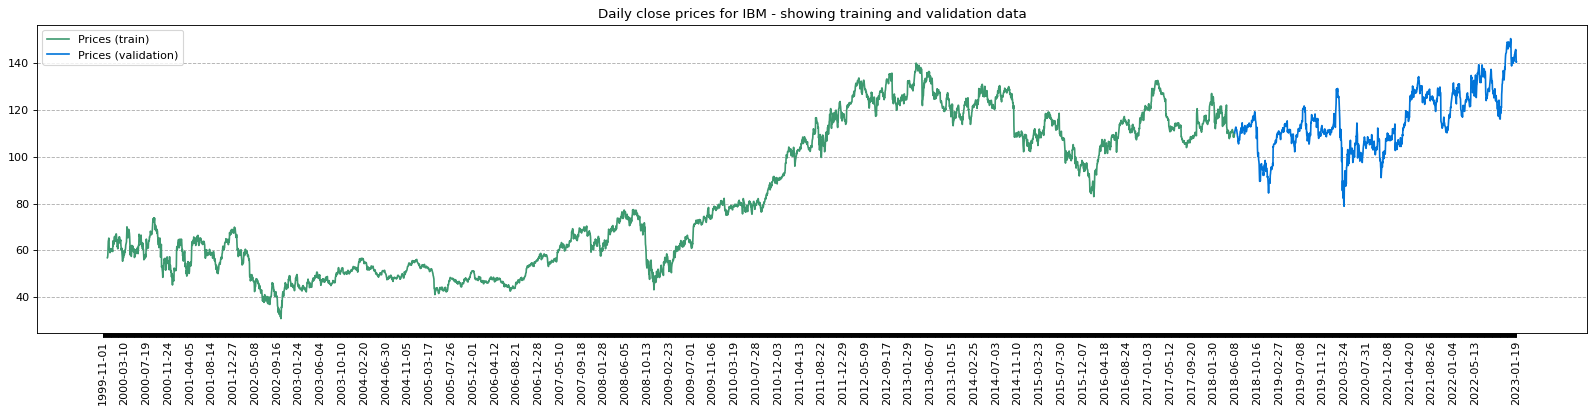

In [22]:
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

What we see above is that all the data up to August 2018 is being used to train the machine (Green), whilst the data from August 2018 onwards is being used to validate the machine (Blue). 

Finally, to complete the data preparation, we must create a `Dataset` object to be used by PyTorch to create our LSTM. We define the class and methods below.

In [23]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

We apply to our datasets to make `Dataset` objects.

In [25]:
dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (4657, 20, 1) (4657,)
Validation data shape (1165, 20, 1) (1165,)


Finally we put this into the `DataLoader` object from PyTorch, which is an efficient data generation scheme that leverages the full potential of your computer's Graphics Processing Unit (GPU) during the training process where applicable.

In [26]:
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

***
## Defining the LSTM ##